In [348]:
# imports

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import pandas as pd
import random
import seaborn as sns
import pymc3 as pm
import time
from pymc3.distributions.dist_math import normal_lcdf, normal_lccdf
import theano.tensor as tt
import scipy.stats as st

%matplotlib inline

# Simulating data

## Population

In [349]:
# Simulate a sample of 2000
n = 2000

In [350]:
# SEPARATIONS (AU)

# modeled as a gaussian of log(separation)
# these parameters based on arxiv.org/abs/1901.06364
# distribution to match st.norm.pdf(np.log(sepatations), np.log(10), np.log(3)) - a peak at 10AU
# these are the mean and standard deviation of the underlying normal distribution
mean = 3.5 #3.5
sigma = 1 #1

sep_physical = np.random.lognormal(mean=mean, sigma=sigma, size=n)

'''
# now modeled as gamma distribution
n = 2000
gamma_mean = 40
gamma_width = 35
gamma_a = gamma_mean**2 / gamma_width**2
gamma_b = gamma_mean / gamma_width**2
sep_physical = np.random.gamma(gamma_a, 1/gamma_b, size=n)
'''

'\n# now modeled as gamma distribution\nn = 2000\ngamma_mean = 40\ngamma_width = 35\ngamma_a = gamma_mean**2 / gamma_width**2\ngamma_b = gamma_mean / gamma_width**2\nsep_physical = np.random.gamma(gamma_a, 1/gamma_b, size=n)\n'

In [351]:
# INVERTED MASS RATIOS and MASS RATIOS

# Modeled as a Pareto distribution
# Define Pareto shape (a) and scale/minimum (m)
a = 1.2
m = 1

mass_ratios_inverted = (np.random.pareto(a, size=n) + 1)*m
mass_ratios = 1/mass_ratios_inverted

In [352]:
# DISTANCES (PARSECS)
# Limiting to 100 pc around us, the distances should follow a power law with index 2, as n increases with r^2
#dist_physical  = np.random.power(3, size=n)*150               # in parsecs
dist_physical  = np.random.beta(2, 4, size=n)*300               # in parsecs

# PARALLAX
dist_parallax = 1/dist_physical

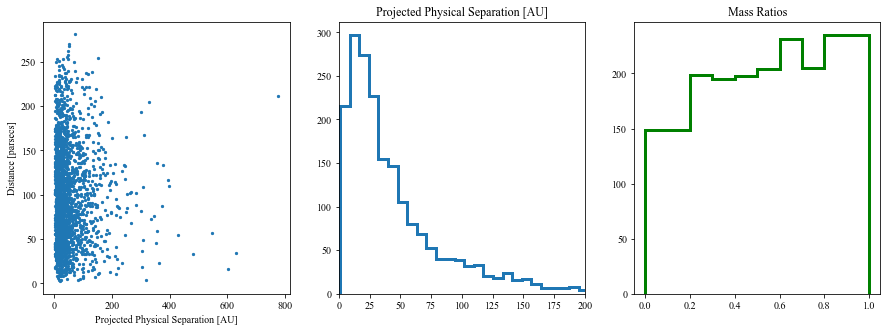

In [353]:
# Look at the distributions of the physical parameters of the systems
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(sep_physical, dist_physical, s=5)
plt.xlabel('Projected Physical Separation [AU]')
plt.ylabel('Distance [parsecs]')

plt.subplot(132)
plt.hist(sep_physical, bins=100, histtype='step', linewidth=3)
plt.xlim(0, 200)
plt.title('Projected Physical Separation [AU]');

plt.subplot(133)
plt.title('Mass Ratios')
plt.hist(mass_ratios, histtype='step', color='g', linewidth=3);

In [354]:
# saving original population 
original_population = pd.DataFrame(np.transpose(np.array([sep_physical, dist_physical, mass_ratios])), 
                            columns = ['sep_physical', 'dist_physical', 'mass_ratio'])

## Observatbles

**Separations:**

$\text{parallax }["] =\frac{1}{\text{distance }[pc] }$

$\text{angular separation }["] = \big(\text{physical separation }[AU]\big)\ \  x\ \ \big(\text{parallax }["]\big)$


**Contrast Ratios:**

From section 4.4 of (Lamman et al), we have an emperical relationship between the inverse mass ratio ($\frac{1}{R_m}$) and inverse Robo-AO contrast ratio ($\frac{1}{R_c}$), given by a 4th degree polynomial:

$1/R_c = 20.3 - 63.1(1/R_m) + 72.5(1/R_m)^2 -40.4(1/R_m)^3  +10.6(1/R_m)^4$

In [355]:
# from inverse mass ratios to inverse contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_icr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return 1 / g(1/x)

def imr_to_cr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return g(1/x)

In [356]:
# TRANSFORM PHYSICAL SEPARATIONS TO ANGULAR SEPARATIONS
sep_angular = sep_physical / dist_physical

# TRANSFORM INVERSE MASS RATIOS TO INVERSE CONTRAST RATIOS
#contrast_ratios_inverted = imr_to_icr(mass_ratios_inverted)
#contrast_ratios = 1/contrast_ratios_inverted
contrast_ratios = imr_to_cr(mass_ratios_inverted)

## Measurements

Robo-AO Errors for all angular separations $\approx 0.07"$

Gaia parallax errors $\approx 0.005$ (Max is $\sim 0.015$, but will ignore parallax errors for now)

Here I'll just use a rought estimate of typical Robo-AO contrast errors. I'll model it as mostly random but higher for systems at close separations.

In [357]:
# ADD ERRORS FOR MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS

# Separations
sep_ang_e = 0.07

# Contrasts
cr_err = np.random.random_sample((len(contrast_ratios),))/10
cr_err = ((cr_err/(sep_angular**2))*(np.random.random()))
cr_err+= 0.001
##plt.hist(cr_err, histtype='step', bins=10000);
##plt.xlim(0, 1);

In [358]:
# SAMPLE THE MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS FROM GAUSSIANS AROUND THE OBSERVABLE SEPs AND CRs

sep_measured = np.random.normal(loc=sep_angular, scale=sep_ang_e)

# contrast ratios are, by definition > 0 
cr_measured = np.abs(np.random.normal(loc=contrast_ratios, scale = cr_err))

# resample until all are positive
##while True:
##    cr_measured = np.random.normal(loc=contrast_ratios, scale = cr_err)
##    if (cr_measured<0).sum() == 0:
##        break

## Catalog

**MAPPING**
 
Robo-AO will generally only detect a companion if:

1. $(\text{angular separation})\  < 4.0"$   (Survey only looked within $4"$, 0.1" is )


2. $(\text{Robo-AO contrast})\  < 1.8\ \ln{(\text{angular separation ["])}} + 3.8$<br>
_This is a ROUGH model of a typical Robo-AO contrast curve, and should be improved in the future by creating a model based on the average contrast curve of each observation in the survey, or take into account individual contrast curves._

In [359]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
sep_min_s = 0.5
sep_max_s = 4.0
cr_min_s = 0.01 
cr_max_s = 3.5

# limit for contrast ratio
# this is a rough approximation made by eye - should eventually be updated
def cr_max(separation):
    #return 1.8 * np.log(separation) + 3.8
    return cr_max_s

In [360]:
measurements = pd.DataFrame({'asep':sep_measured,'asep_err':[sep_ang_e]*len(sep_angular),
                                 'cr':cr_measured, 'cr_err':cr_err,
                                 'parallax':dist_parallax})

# Apply the observational limitations to get our synthetic catalog
catalog = measurements.loc[
    (measurements['asep']<sep_max_s) & 
    (measurements['asep']>sep_min_s) & 
    (measurements['cr']>cr_min_s) &
    (measurements['cr']<cr_max(measurements['asep']))]

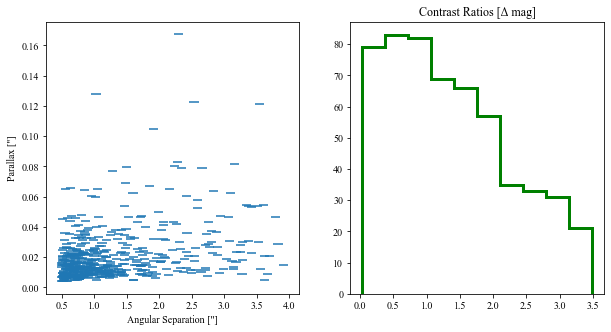

In [361]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.errorbar(catalog['asep'], catalog['parallax'], xerr=sep_ang_e, ls='none') #yerr=dist_parallax_e
plt.xlabel('Angular Separation ["]')
plt.ylabel('Parallax ["]')

plt.subplot(122)
plt.title(u'Contrast Ratios [Δ mag]')
plt.hist(catalog['cr'], histtype='step', color='g', linewidth=3);

"Recreating" Fig 6 in the original survey paper<br>
(https://arxiv.org/pdf/2001.05988.pdf)

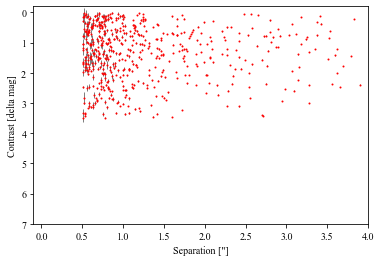

In [362]:
plt.errorbar(catalog['asep'], catalog['cr'], yerr=catalog['cr_err'], 
             marker='.', mec='r', ms=2, ls='none', linewidth=1, ecolor='grey')
plt.ylim(7, -0.2); plt.xlim(-0.1, 4)
plt.xlabel('Separation ["]'); plt.ylabel('Contrast [delta mag]');

In [363]:
prcnt_in = len(catalog)/len(original_population) * 100
print('This catalog contains '+str(prcnt_in)+'% of the original multiples')

This catalog contains 27.800000000000004% of the original multiples


0.0011983081606101633
0.011693221163346479


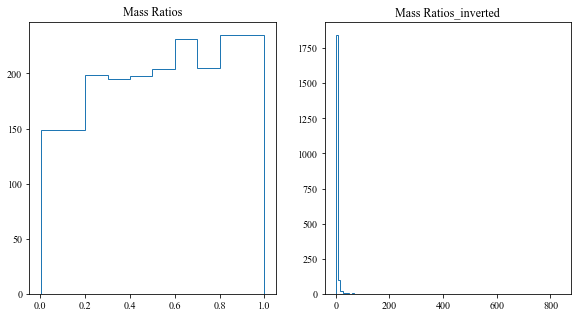

In [365]:
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(original_population['mass_ratio'], bins=10, histtype='step')
plt.title('Mass Ratios');

plt.subplot(132)
plt.hist(1/original_population['mass_ratio'], bins=100, histtype='step')
plt.xlim
plt.title('Mass Ratios_inverted');
print(np.min(mass_ratios))
print(np.min(contrast_ratios))

##plt.subplot(133)
#plt.hist()

0.0010421954658881426


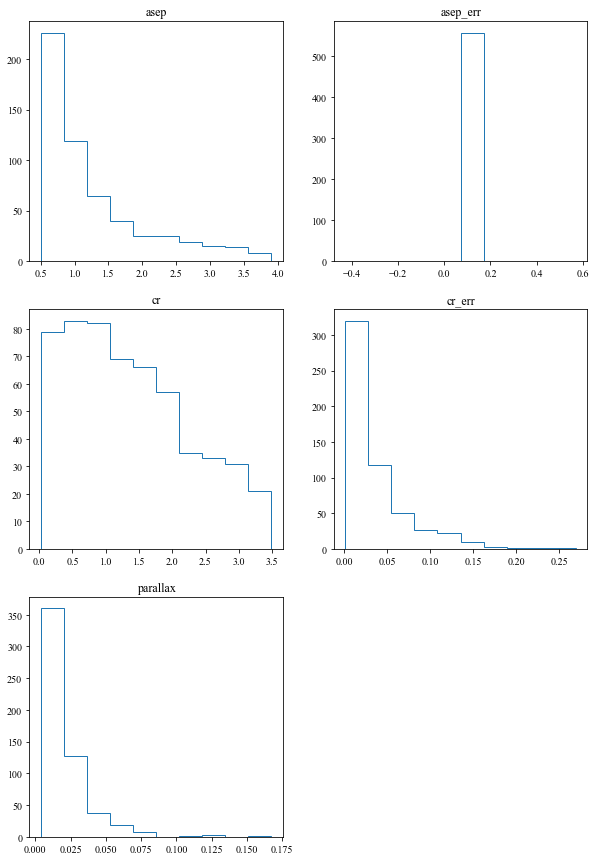

In [366]:
data = catalog
op = original_population

fig = plt.figure(figsize=(10, 15))

i = 1
for j in ['asep', 'asep_err', 'cr', 'cr_err', 'parallax']:
    
    fig.add_subplot(3,2,i)
    plt.title(j)
    plt.hist(data[j], histtype='step');
    i+=1
    
print(np.min(data['cr_err']))

# Modeling and Fitting Simulated Data

In [367]:
data = catalog
op = original_population

In [368]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
def sep_max(contrast):
    return sep_max_s


def sep_min(contrast):
    '''returns the minimum separation that can be detected for a given contrast ratio'''
    #return np.exp((cr-3.8)/1.8)
    return sep_min_s

# limit for high contrast ratio and low separations
# this is a rough approximation made by eye - should eventually be updated
def cr_max(separation):
    '''returns the maximum contrast ratio which can be detected at a given separations'''
    #return (1.8 * np.log(separation) + 3.8)
    return cr_max_s

def cr_min(separation):
    return cr_min_s


# from inverse mass ratios to contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_cr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return g(1/x)

In [508]:
def left_censored_likelihood(mu, sigma, n_left_censored, lower_bound):
    ''' Likelihood of left-censored data. '''
    return n_left_censored * normal_lcdf(mu, sigma, lower_bound)
def right_censored_likelihood(mu, sigma, n_right_censored, upper_bound):
    ''' Likelihood of right-censored data. '''
    return n_right_censored * normal_lccdf(mu, sigma, upper_bound)

In [677]:
def pymc3_hrchl_fit(data, tune=1000, nsteps=1000):
    asep = data['asep'].values
    asep_err = data['asep_err'].values
    cr = data['cr'].values
    cr_err = data['cr_err'].values
    ##cr_err = 0.2
    parallax = data['parallax'].values
    #mass_ratio_data = data['mass_ratios'].values
    #psep_data = data['psep'].values
    
    with pm.Model() as hierarchical_model:

        # PRIORS
        # -------------
        
        # Separations
        #width = pm.Gamma('width', mu=1.1, sigma=0.5)
        center = pm.Gamma('center', mu=5, sigma=3)
        
        width = pm.Weibull('width', alpha=2, beta=1)
        ##asep_width = st.lognorm.fit(catalog['asep'])[0]
        ##width_guess = -6.63 + 8.8*asep_width
        ##print(width_guess)
        ##width = pm.Weibull('width', alpha=2, beta=width_guess)
        
        #--gamma separations---
        ##center = pm.Gamma('center', alpha=1.77, beta=0.44)
        ##width = pm.Gamma('width', alpha=1.77, beta=0.44) 
        
        
        # power_index 
        ##power_index = pm.Normal('power_index', mu=1.2, sigma=.1)
        ##pia= pm.Gamma('pia', mu=.2, sigma=.12)
        ##power_index = pm.Deterministic('power_index', pia+1)
        ##power_index = pm.TruncatedNormal('power_index', mu=1.2, sigma=.5, lower=1)
        
        
        # MODELS OF POPULATIONS PHYSICAL PROPERTIES
        # --------------
        
        # Gaussian model for separations (in AU)
        sep_physical = pm.Lognormal('sep_physical', mu=center, sigma=width, shape=len(asep))
        
        # Mass Ratios - inverted
        ##mass_ratios_inverted = pm.Pareto('mass_ratios_inverted', alpha=power_index, m=1, shape=len(cr))
        
        
        # MAPPING FROM PHYSICAL TO OBSERVED PROPERTIES
        # ---------------

        #  physical separations to angular separations
        sep_angular = pm.Deterministic('sep_angular', sep_physical * parallax)
        
        # inverted mass ratios to contrast ratios
        ##contrast_ratios = pm.Deterministic('contrast_ratios', imr_to_cr(mass_ratios_inverted))
        
        
        
        # LIKELIHOODS, WITH MEASUREMENT ERROR
        # -----------------
        
        # separations
        sep_observed = pm.Normal('sep_observed', mu=sep_angular, sigma=asep_err, observed=asep)
        
        # contrast ratios
        ##cr_observed = pm.Normal('cr_observed', mu=contrast_ratios, sigma=cr_err, observed=cr)
        
        
        # ACCOUNTING FOR OBSERVATION LIMITS
        # ------------------
        
        # integrate out the points which fall outside of the observation limits from the likelihood
        # pm.Potential accounts for truncation and normalizes likelihood
        
        
        # x is bound variable, X is random variable
        # cdf: probability that X <= x (use with an upper bound)
        # ccdf: ccdf = 1 - cdf         (use with a lower bound)
        
        
        # separation limits
        truncated_seps = pm.Potential(
            'truncated_seps',
            -pm.math.logdiffexp(normal_lcdf(sep_angular, asep_err, sep_max(cr)),
                                normal_lcdf(sep_angular, asep_err, sep_min(cr))))
        
        ##truncated_seps = pm.Potential(
        ##    'truncated_seps',
        ##    -pm.math.logdiffexp(normal_lcdf(sep_angular, asep_err, sep_max(cr)),
        ##                        normal_lcdf(sep_angular, asep_err, sep_min(cr))))
        
        ##utruncated_seps = pm.Potential('utruncated_seps', normal_lccdf(sep_observed, asep_err, sep_max(cr)))
        ##ltruncated_seps = pm.Potential('ltruncated_seps', normal_lcdf(sep_observed, asep_err, sep_min(cr)))
        ##truncated_seps_upper = pm.Potential('upper_truncated_seps', -normal_lcdf(sep_angular, asep_err, sep_max(cr)))
        ##truncated_seps_lower = pm.Potential('lower_truncated_seps', normal_lcdf(sep_angular, asep_err, sep_min(cr)))
        
        
        #---------old likelihood method--------------
        # RVs for the number of data points which fall outside of the observational range
        # Jeffrey's prior, following https://arxiv.org/pdf/1804.02474.pdf
        #n_seps_rtrunc_a = pm.Uniform('n_seps_rtrunc_a', lower=.1, upper=3)
        #n_seps_rtrunc = pm.Potential('n_seps_rtrunc', -tt.log(n_seps_rtrunc_a))
        
        #n_seps_ltrunc_a = pm.Uniform('n_seps_ltrunc_a', lower=.1, upper=4)
        #n_seps_ltrunc = pm.Potential('n_seps_ltrunc', -tt.log(n_seps_ltrunc_a))

        
        #right_truncated_seps = pm.Potential('seps_rtruncated', -right_censored_likelihood(
        #    sep_angular, asep_err, n_seps_rtrunc, sep_max(cr)))
        #left_truncated_seps = pm.Potential('seps_ltruncated', left_censored_likelihood(
        #    sep_angular, asep_err, n_seps_ltrunc, sep_min(cr)))
        
        #---------old likelihood method--------------
        
        
        
        
        #---------------------
        # contrast ratio limits - function of separations
        ##truncated_crs = pm.Potential('crs_truncated', normal_lccdf(cr_observed, cr_err, cr_max(sep_observed)))
        ##truncated_crs_inverse = pm.Potential('crs_truncated_inverse', normal_lcdf(
        ##    cr_observed_inverse, cr_err_inverted, icr_max(sep_observed)))
        ##truncated_crs = pm.Potential('crs_truncated', normal_lcdf(contrast_ratios, cr_err, cr_max(asep)))
        
        ##truncated_crs = pm.Potential(
        ##    'truncated_crs',
        ##    -pm.math.logdiffexp(normal_lcdf(contrast_ratios, cr_err, cr_max(asep)),
        ##                        normal_lcdf(contrast_ratios, cr_err, cr_min(asep))))
        #--------------------------

        
        # RUNNING THE FIT
        # -------------------
        # Use random_seed so that we can debug any mass_matrix=0 errors
        # To debug, look at the step number i where the sampler fails,
        # then run the sampler again using i-1 steps, then look at the
        # traces and look for strange values
        traces = pm.sample(tune=tune, draws=nsteps, step=None, chains=1, random_seed=1)
        
        # output as dataframe
        df = pm.trace_to_dataframe(traces)
    return traces, df

In [678]:
ta = time.time()
traces, samples = pymc3_hrchl_fit(data, tune=500, nsteps=1000)
tb = time.time()
print('Fit finished, took',round((tb -ta)/60., 1),' minutes' )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [n_seps_ltrunc_a, n_seps_rtrunc_a, sep_physical, width, center]
Sampling chain 0, 0 divergences: 100%|█████| 1500/1500 [00:43<00:00, 34.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Fit finished, took 0.9  minutes


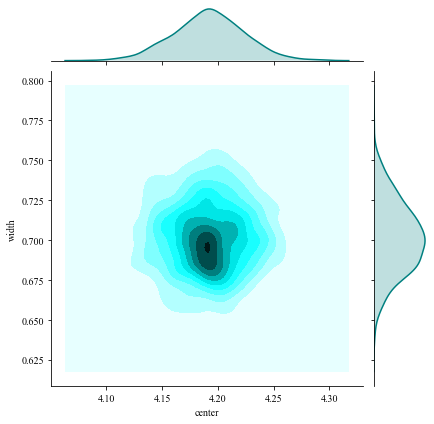

In [666]:
sns_plot = sns.jointplot(x='center', y='width', data=samples, kind='kde', color='teal');

In [667]:
##import warnings # arviz outputs a bunch of deprecation warnings; this code prevents them from being printed
##with warnings.catch_warnings():
##    warnings.simplefilter("ignore")
##    pm.traceplot(traces)

In [668]:
# estimate of the MAP
q = samples.quantile([0.16,0.50,0.84], axis=0)
c_lower, c, c_upper = q['center']
w_lower, w, w_upper = q['width']

##p_lower, p, p_upper = q['power_index']

## Comparing Results to Original Population

In [669]:
# functions to plot
import scipy.stats as st
    
def plot_power_law(index, data, bins, label):
    xs = np.linspace(0, np.max(data), 100)
    ys = index*xs**(index-1.)
    normed_y = len(data)*np.diff(bins)[0]*ys
    plt.plot(xs, normed_y, label=label);
    
def plot_lognorm(mu, sigma, data, bins, label):
    xs = np.linspace(0, np.max(data), 10000)
    pdfn = st.lognorm.pdf(xs, sigma, scale=np.exp(mu))
    normedy = len(data)*np.diff(bins)[0]*pdfn
    plt.plot(xs, normedy, label=label)
    
    
def plot_gamma(mu, sigma, data, bins, label):
    a = mu**2 /sigma**2
    b = mu / sigma**2
    xs = np.linspace(0, np.max(data), 10000)
    ys = st.gamma.pdf(xs, a, scale=1.0/b)
    normed_y = len(data)*np.diff(bins)[0]*ys
    plt.plot(xs, normed_y, label=label)

center = 4.19 + 0.03 - 0.03
width = 0.7 + 0.0 - 0.0


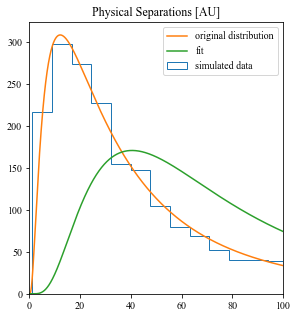

In [670]:
# testing against distributions used to make simulated data

fig = plt.figure(figsize=(10,5))

#'''
plt.subplot(121)
plt.title('Physical Separations [AU]')
count, bns, ignored = plt.hist(op['sep_physical'], histtype='step', label='simulated data', bins=100, linewidth=1)
plot_lognorm(mean, sigma, op['sep_physical'], bns, 'original distribution')
plot_lognorm(c, w, op['sep_physical'], bns, 'fit')
#plot_gamma(c, w, op['sep_physical'], bns, 'gamma fit')
plt.xlim(0, 100)
plt.legend();
print("center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
print("width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))
#'''
'''
plt.subplot(122)
plt.title('Mass Ratios')
count, bns, ignored = plt.hist(op['mass_ratio'], histtype='step', label='simulated data', bins=10, linewidth=2)
plot_power_law(a, op['mass_ratio'], bns, 'original distribution')
plot_power_law(p, op['mass_ratio'], bns, 'fit')
plt.legend(loc='lower right');
print("\npower index = {:.2f} + {:.2f} - {:.2f}".format(p, p_upper-p, p-p_lower))
''';

#fig.savefig('model_fit_v.png', dpi=200)

In [ ]:
sns_plot = sns.jointplot(x='center', y='width', data=samples, kind='kde', color='teal');

In [ ]:
sns_plot = sns.jointplot(x='power_index', y='center', data=samples, kind='kde', color='darkred');